In [974]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from setup import get_task_data

In [975]:
df_amd = pd.read_csv(get_task_data('AMD.csv'), index_col='Date', parse_dates=True)
df_amd.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1982-06-01,0.000000,4.020833,3.895833,3.958333,3.958333,260400
1981-06-25,0.000000,4.000000,3.833333,3.895833,3.895833,486600
2011-07-18,6.370000,6.430000,6.090000,6.180000,6.180000,31233200
2021-02-23,83.400002,85.110001,79.360001,84.739998,84.739998,49720900
1991-08-01,5.625000,5.937500,5.625000,5.750000,5.750000,1235400


In [976]:
amd_max, amd_min = df_amd.index.max(), df_amd.index.min()
amd_min, amd_max

(Timestamp('1980-03-17 00:00:00'), Timestamp('2023-10-06 00:00:00'))

In [977]:
df_intel = pd.read_csv(get_task_data('INTC.csv'), index_col='Date', parse_dates=True)
df_intel.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-08-15,8.375000,8.406250,8.078125,8.187500,4.692369,67754400
1988-03-21,0.984375,0.984375,0.949219,0.968750,0.549177,29228800
2010-10-28,20.290001,20.530001,20.020000,20.469999,13.783585,71144000
1988-11-02,0.773438,0.773438,0.757813,0.773438,0.438456,42425600
1994-10-04,3.765625,3.781250,3.624023,3.625000,2.071172,131020800


In [978]:
intel_max, intel_min = df_intel.index.max(), df_intel.index.min()
intel_min, intel_max

(Timestamp('1980-03-17 00:00:00'), Timestamp('2023-10-16 00:00:00'))

### Get last 3 years data

In [979]:
def filter_dates(df: pd.DataFrame, max_date, years_num = 3) -> pd.DataFrame:
    print('Before', len(df))
    df = df.loc[pd.to_datetime(max_date) - datetime.timedelta(days = 365 * years_num): max_date]
    print('After', len(df))
    return df

df_amd = filter_dates(df_amd, amd_max)
df_intel = filter_dates(df_intel, amd_max)

Before 10983
After 756
Before 10989
After 756


In [980]:
df_merged = pd.merge(df_amd, df_intel, how='inner', left_index=True, right_index=True, suffixes=('_AMD', '_Intel'))
df_merged

,Open_AMD,High_AMD,Low_AMD,Close_AMD,Adj Close_AMD,Volume_AMD,Open_Intel,High_Intel,Low_Intel,Close_Intel,Adj Close_Intel,Volume_Intel
Date,,,,,,,,,,,,
2020-10-06,86.209999,87.250000,83.540001,84.480003,84.480003,52725400,51.709999,52.700001,51.230000,51.369999,46.875542,25642800
2020-10-07,86.099998,87.790001,85.650002,86.690002,86.690002,43045700,51.849998,52.900002,51.790001,52.669998,48.061802,21978700
2020-10-08,88.110001,88.720001,85.949997,86.510002,86.510002,54240700,52.910000,53.580002,52.669998,53.369999,48.700550,22369500
2020-10-09,84.739998,85.750000,82.349998,83.099998,83.099998,80354400,53.549999,53.849998,52.669998,52.820000,48.198669,24343900
2020-10-12,83.650002,85.129997,83.120003,84.290001,84.290001,47669700,53.549999,54.200001,53.209999,53.880001,49.165936,27303500
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,102.209999,103.709999,101.699997,103.269997,103.269997,45118600,35.610001,35.980000,34.980000,35.459999,35.459999,26086200
2023-10-03,101.800003,103.290001,99.169998,100.080002,100.080002,48117000,35.270000,36.540001,35.270000,35.689999,35.689999,45292600
2023-10-04,100.650002,104.400002,100.339996,104.070000,104.070000,51023200,36.520000,36.520000,35.330002,35.930000,35.930000,39842200


In [981]:
TRADE_BATCH = 100

Mean reversion strategy:

Mean reversion strategy relies on hypothesis that stock price always comes to it's mean.
That means it must be profitable to buy the stock whenever its price is lower than mean and sell whenever price is higher.

In [982]:
def mean_reversion_strategy(data, stock1, stock2, lookback_period=15, z_score_threshold=2.25):
    data['Rolling_mean_1'] = data[stock1].rolling(window=lookback_period).mean()
    data['Z_Score_1'] = (data[stock1] - data['Rolling_mean_1']) / data[stock1].rolling(window=lookback_period).std()

    data['Signal_1'] = 0.0
    data.loc[data['Z_Score_1'] < -z_score_threshold, 'Signal_1'] = TRADE_BATCH
    data.loc[data['Z_Score_1'] > z_score_threshold, 'Signal_1'] = -TRADE_BATCH

    data['Rolling_mean_2'] = data[stock2].rolling(window=lookback_period).mean()
    data['Z_Score_2'] = (data[stock2] - data['Rolling_mean_2']) / data[stock2].rolling(window=lookback_period).std()

    data['Signal_2'] = 0.0
    data.loc[data['Z_Score_2'] < -z_score_threshold, 'Signal_2'] = TRADE_BATCH
    data.loc[data['Z_Score_2'] > z_score_threshold, 'Signal_2'] = -TRADE_BATCH

    return data

Trend following strategy:

Trend following strategies rely on trend, but use heuristics and other metrics to determine the right time to buy/sell.
For such metric we chose MACD (Moving average convergence/divergence): 

Track long and short trends through exponential moving averages
Their convergence\divergence can be defined as their difference
MACD trend is also tracked and actions made when MACD is higher\lower than it's trend

In [983]:
def trend_following_strategy(data, stock1, stock2, short_window=12, long_window=26, signal_window=9):
    data['Short_MA_1'] = data[stock1].ewm(span=short_window, min_periods=1, adjust=False).mean()
    data['Long_MA_1'] = data[stock1].ewm(span=long_window, min_periods=1, adjust=False).mean()
    data['MACD_1'] = (data['Short_MA_1'] - data['Long_MA_1'])
    data['Signal_MA_1'] = data['MACD_1'].ewm(span=signal_window, min_periods=1, adjust=False).mean()
    data['SignalDiff_1'] = np.sign(data['MACD_1'] - data['Signal_MA_1']).diff()

    data['Signal_1'] = 0.0
    data.loc[data['SignalDiff_1'] > 0, 'Signal_1'] = TRADE_BATCH
    data.loc[data['SignalDiff_1'] < 0, 'Signal_1'] = -TRADE_BATCH

    data['Short_MA_2'] = data[stock2].ewm(span=short_window, min_periods=1, adjust=False).mean()
    data['Long_MA_2'] = data[stock2].ewm(span=long_window, min_periods=1, adjust=False).mean()
    data['MACD_2'] = (data['Short_MA_2'] - data['Long_MA_2'])
    data['Signal_MA_2'] = data['MACD_2'].ewm(span=signal_window, min_periods=1, adjust=False).mean()
    data['SignalDiff_2'] = np.sign(data['MACD_2'] - data['Signal_MA_2']).diff()

    data['Signal_2'] = 0.0
    data.loc[data['SignalDiff_2'] > 0, 'Signal_2'] = TRADE_BATCH
    data.loc[data['SignalDiff_2'] < 0, 'Signal_2'] = -TRADE_BATCH

    return data

Statistical arbitrage strategy:

Statistical arbitrage strategies rely on hypotheses about in-market relations between stocks.

We chose the simplest arbitrage strategy - pairs trading. 
It's hypothesis is that with two highly related stocks we will see the same trends (which is basically what makes them related),
but they can be a litte shifted. Yet, we expect them to average from that state which makes one stock overpriced and other underpriced.

In [984]:
def statistical_arbitrage_strategy(data, stock1, stock2, lookback_period=20, threshold=1.0):
    ratio = data[stock1] / data[stock2]
    z_score = (ratio - ratio.rolling(window=lookback_period).mean())

    data['Signal_1'] = 0.0
    data.loc[z_score > threshold, 'Signal_1'] = -100
    data.loc[z_score < -threshold, 'Signal_1'] = 100

    # apply mirrored action to second stock
    data['Signal_2'] = -data['Signal_1']

    return data

In [985]:
def initialize_portfolio(data, initial_capital=10000.0):    
    data['Stocks_1'] = 0
    data['Stocks_1_Value'] = 0.0
    
    data['Stocks_2'] = 0
    data['Stocks_2_Value'] = 0.0

    data['Cash_1'] = initial_capital / 2
    data['Cash_2'] = initial_capital / 2
   
    data['Portfolio Value'] = initial_capital

In [986]:
def sharpe_coefficient(data, risk_free_rate = 1.0001):
    risk_free = np.empty((len(data),))
    risk_free[0] = 1
    risk_free[1:] = risk_free_rate

    data['Returns_RiskFree'] = np.cumprod(risk_free) # geometric progression with coef risk_free_rate
    data['Excess'] = data['Returns'] - data['Returns_RiskFree']

    mean = data['Excess'].mean()
    std = data['Excess'].std()

    return mean / std

def maximum_drawdown(data):
    data['Peak'] = data['Portfolio Value'].cummax()    
    data['Drawdown'] = (data['Portfolio Value'] - data['Peak']) / data['Peak']
    return data['Drawdown'].min()

def profit_coefficient(data):
    return data['Returns'].iloc[-1]

In [987]:
pd.set_option('mode.chained_assignment', None)

def clamp_signal(data, index, signal_col, stock_col, cash_col, price_col):
    signal = data[signal_col].iloc[index]
    
    if signal > 0:
        cash = data[cash_col].iloc[index]
        price = data[price_col].iloc[index]
        max_buy = cash / price if cash > 0 else 0

        signal = min(signal, max_buy)

    
    if signal < 0:
        stock = data[stock_col].iloc[index]
        signal = -stock

    return np.fix(signal)

def backtest(data, target_col: str, pair_target_col: str):
    for i in range(1, len(data)):
        data['Stocks_1'].iloc[i] = data['Stocks_1'].iloc[i-1] + data['Signal_1'].iloc[i-1]
        data['Stocks_2'].iloc[i] = data['Stocks_2'].iloc[i-1] + data['Signal_2'].iloc[i-1]
        
        data['Cash_1'].iloc[i] = data['Cash_1'].iloc[i-1] - data['Signal_1'].iloc[i-1] * data[target_col].iloc[i-1] 
        data['Cash_2'].iloc[i] = data['Cash_2'].iloc[i-1] - data['Signal_2'].iloc[i-1] * data[pair_target_col].iloc[i-1] 

        data['Signal_1'].iloc[i] = clamp_signal(data, i, 'Signal_1', 'Stocks_1', 'Cash_1', target_col)
        data['Signal_2'].iloc[i] = clamp_signal(data, i, 'Signal_2', 'Stocks_2', 'Cash_2', pair_target_col)

        data['Stocks_1_Value'].iloc[i] = data['Stocks_1'].iloc[i] * data[target_col].iloc[i]
        data['Stocks_2_Value'].iloc[i] = data['Stocks_2'].iloc[i] * data[pair_target_col].iloc[i]
        data['Portfolio Value'].iloc[i] = (data['Cash_1'].iloc[i] + data['Cash_2'].iloc[i] 
            + data['Stocks_1_Value'].iloc[i] + data['Stocks_2_Value'].iloc[i])

    data['Returns'] = (data['Portfolio Value'].pct_change() + 1).cumprod()
    data['Cash'] = data['Cash_1'] + data['Cash_2']

    return (sharpe_coefficient(data), maximum_drawdown(data), profit_coefficient(data))

In [988]:
def analyze_strategy(strategy: callable, merged_df: pd.DataFrame, target_col: str, pair_target_col: str):
    df = strategy(merged_df, target_col, pair_target_col)
    initialize_portfolio(df)
    
    sharpe, max_drawdown, profit = backtest(df, target_col, pair_target_col)
    column = target_col.split('_')[0]
    
    plt.figure(figsize=(10, 6))
    
    labels = ["Cash ", "Stocks_1_Value", "Stocks_2_Value"]
    plt.stackplot(df.index, df['Cash'], df['Stocks_1_Value'], df['Stocks_2_Value'], labels=labels)
    
    plt.title(f'Portfolio Value - {strategy.__name__} - {column} column')
    plt.legend(loc='upper left')
    plt.show()
    
    print(f'Sharpe index: {sharpe}, Maximum drawdown: {max_drawdown}, Profit coefficient: {profit}')

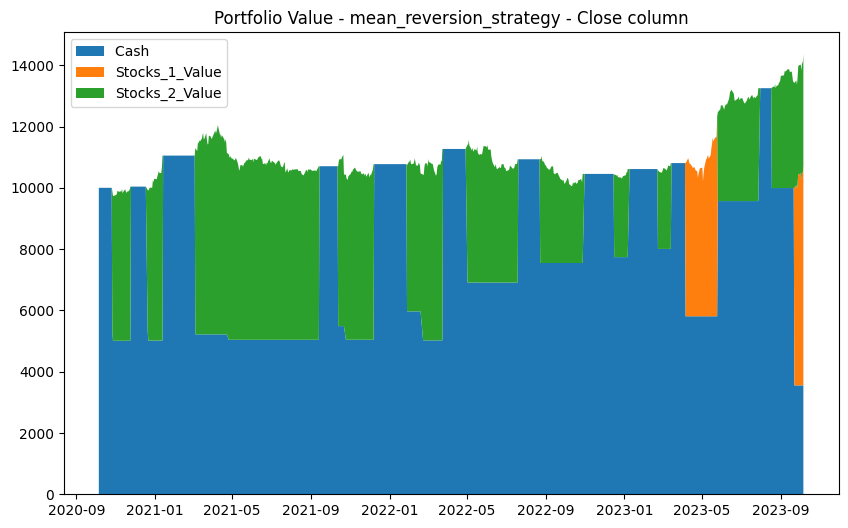

Sharpe index: 0.7849981160176596, Maximum drawdown: -0.16552292699522114, Profit coefficient: 1.4356919958999992


In [989]:
analyze_strategy(mean_reversion_strategy, df_merged.copy(), 'Close_AMD', 'Close_Intel')

Mean reversion strategy shows great results with handpicked window size and threshold which proves underlying hypothesis.

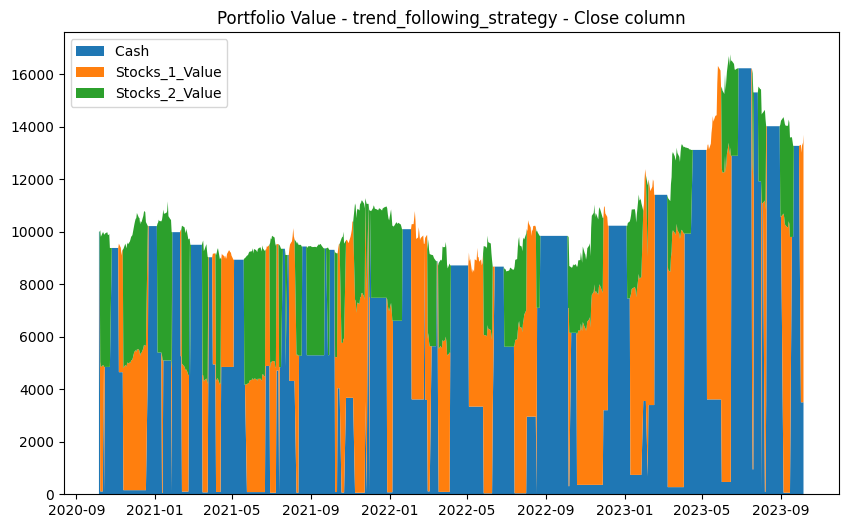

Sharpe index: 0.14042096655768505, Maximum drawdown: -0.2520260594123032, Profit coefficient: 1.3691638947999967


In [990]:
analyze_strategy(trend_following_strategy, df_merged.copy(), 'Close_AMD', 'Close_Intel')

Trend following strategy shows good results too, even without tuning (rule of thumb coefficients were chosen). 
However it makes a lot of errors (at least more than mean reversion) which can be seen from graph, sharpe index and maximum dropdown.

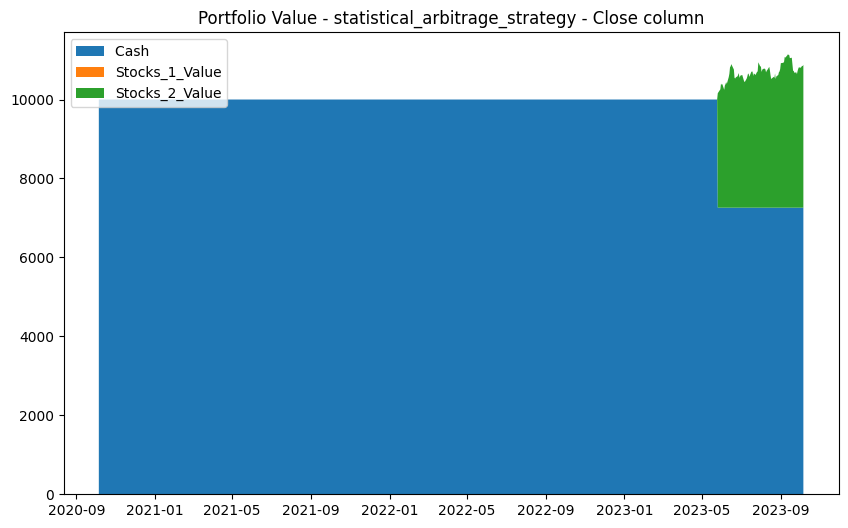

Sharpe index: -1.3854006926346845, Maximum drawdown: -0.04512828777024674, Profit coefficient: 1.0878999899999995


In [991]:
analyze_strategy(statistical_arbitrage_strategy, df_merged.copy(), 'Close_AMD', 'Close_Intel')

Statistical arbitrage strategy shows bad results for our pair of stocks. Without tuned values hypothesis performed even worse, becoming a non-profit. It current state is a very safe strategy that generates very small profit (in a long time, it can make great results in a short time like last 4 months). From sharpe index it can be seen that the profit is smaller than expected risk-free profit.

It states that hypothesis about high correlation between chosen stocks is not very helpful, but still it's true. In some occasions it can be very profitable. Such model can be mixed with other strategies and perform well.